### Hypothesis:- Majority of authors publish research article in a single specialized field,But a section of authors engages in interdisciplinary work.

##### first we will load data into the dataframe in small chunks as dataset is very big.we will be loading only selective columns which are required for analysis.

In [2]:
import pandas as pd
import os


file_path = r'C:\Users\amrit\Downloads\processed_arxiv_data.csv'
columns_to_keep = ['title', 'authors', 'categories', 'abstract', 'update_date']

if not os.path.exists(file_path):
    raise FileNotFoundError(f"File not found: {file_path}")

chunks = []


chunk_size = 10000  
with pd.read_csv(file_path, chunksize=chunk_size) as reader:
    for i, chunk in enumerate(reader):
       
        
        
        
        present_columns = [col for col in columns_to_keep if col in chunk.columns]
        chunk_filtered = chunk[present_columns]
        
        
        if chunk_filtered.empty:
            print(f"Chunk {i} is empty after filtering columns.")
        else:
            
            chunks.append(chunk_filtered)
df= pd.concat(chunks, ignore_index=True)

##### there are multiple sub categories under each stream so we have gouped them all under a parent category (e.g astro-ph.co,astro-ph.EP,astro-ph.GA all have grouped under astro category)

In [3]:
import pandas as pd
import os


df['simplified_category'] = df['categories'].str.split('-').str[0].str.split('.').str[0]

grouped_data = df.groupby('simplified_category').size().reset_index(name='count')

In [4]:
print(df['authors'].head())

0    C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...
1                      Ileana Streinu and Louis Theran
2                                          Hongjun Pan
3                                         David Callan
4             Wael Abu-Shammala and Alberto Torchinsky
Name: authors, dtype: object


In [5]:
import re
df['author_count'] = df['authors'].apply(lambda x: len(re.split(r',| and ', x)))

##### To get the name of all the authors of a certain paper we have splited them by coma and 'and'. Then we have created a seperate row for every author and uploded on a new dataframe striping whitespaces.

In [6]:

df['authors'] = df['authors'].str.split(r',| and ')


df_exploded = df.explode('authors')
df_exploded['authors'] = df_exploded['authors'].str.strip()

##### check modified DataFrame with Separate Records for Each Author

In [7]:
print( df_exploded.head())

                                               title         authors  \
0  Calculation of prompt diphoton production cros...     C. Bal\'azs   
0  Calculation of prompt diphoton production cros...    E. L. Berger   
0  Calculation of prompt diphoton production cros...  P. M. Nadolsky   
0  Calculation of prompt diphoton production cros...      C.-P. Yuan   
1           Sparsity-certifying Graph Decompositions  Ileana Streinu   

      categories                                           abstract  \
0         hep-ph    A fully differential calculation in perturba...   
0         hep-ph    A fully differential calculation in perturba...   
0         hep-ph    A fully differential calculation in perturba...   
0         hep-ph    A fully differential calculation in perturba...   
1  math.CO cs.CG    We describe a new algorithm, the $(k,\ell)$-...   

  update_date simplified_category  author_count  
0  2008-11-26                 hep             4  
0  2008-11-26                 hep       

#### We will create a heatmap of the clustering results to demonstrate that a small subset of authors work in interdisciplinary fields.

In [8]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns

##### Calculate the top 10 categories based on cumulative author count

In [12]:

top_categories = (
    df.explode('simplified_category')
    .groupby('simplified_category')['author_count']
    .sum()
    .nlargest(10)
    .index
)




#####  Filter the DataFrame to only include rows with these top 10 categories

In [13]:

df_exploded = df.explode('authors')
df_exploded = df_exploded.explode('simplified_category')
df_exploded = df_exploded[df_exploded['simplified_category'].isin(top_categories)]



##### Create the author-simplified_category matrix using MultiLabelBinarizer

In [14]:

mlb = MultiLabelBinarizer()
author_category_matrix = pd.DataFrame(
    mlb.fit_transform(df_exploded.groupby('authors')['simplified_category'].apply(set)),
    index=df_exploded['authors'].unique(),
    columns=mlb.classes_
)

##### Appling K-mean clustering algorithm and visualizing it in a heatmap 

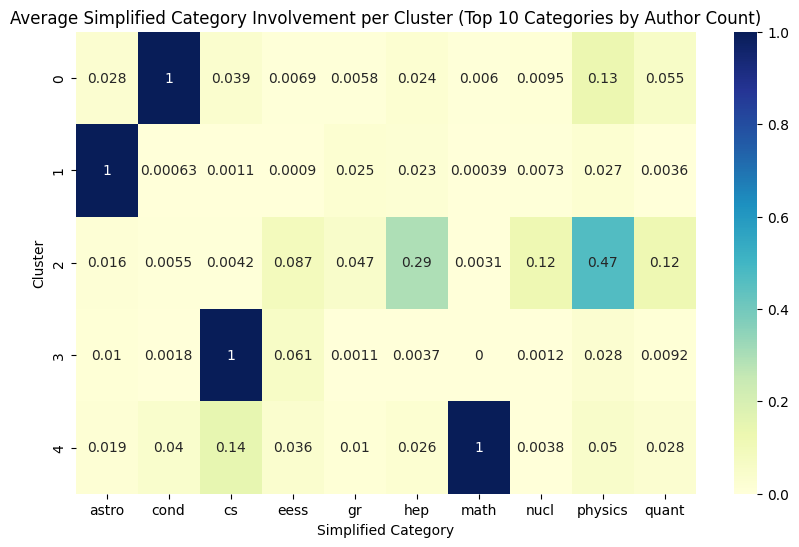

In [15]:

kmeans = KMeans(n_clusters=5, random_state=0)  
author_category_matrix['Cluster'] = kmeans.fit_predict(author_category_matrix)


plt.figure(figsize=(10, 6))
sns.heatmap(author_category_matrix.groupby('Cluster').mean(), cmap="YlGnBu", annot=True)
plt.title("Average Category Involvement per Cluster (Top Categories by Author Count)")
plt.xlabel("Simplified Category")
plt.ylabel("Cluster")
plt.show()

##### Cluster 0 is highly involved with the Condensed Matter (cond) .
##### Cluster 1 has a strong focus on the astronomy category.
##### Cluster 2 has notable involvement in physics,High Energy Physics(hep), and Nuclear Physics(nucl) indicating authors working interdisplinary.
##### Cluster 3 is most involved with Computer science .
##### Cluster 4 predominantly features math.

##### Some category like physics are moderately represented across Clusters. But category like math shows prominence mainly in Cluster 4.